# 뉴스기사 분류모델

## #01. 형태소 분석엔진 설치 (Colab)

In [ ]:
#!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
#!bash Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab_light_220429.sh

## #02. 패키지 참조

### helper 참조

In [1]:
import sys
sys.path.append('../../')
import helper

### 그 밖의 패키지 참조

In [2]:
import os
import numpy as np
import seaborn as sb
import requests

from pandas import DataFrame
from pandas import read_excel
from konlpy.tag import Mecab
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## #03. 데이터셋 준비하기

### 뉴스기사 데이터셋

In [3]:
origin = read_excel("./news.xlsx")
origin.head()

,category,content
0,"IT,과학","“갤럭시S9 20만 원대, 아이폰6S 0원!” 모비톡, 가정의 달 이벤트 '갤럭시노..."
1,"IT,과학",'모비톡' 단독으로 진행되는 5월 가정의 달 이벤트에 이용자들의 폭발적인 반응이 나...
2,"IT,과학","이 밖에도 '모비톡'은 '갤럭시노트8', 'V30' 구매 시 '닌텐도 스위치'를 증..."
3,"IT,과학","LG 그램’, 100만대 판매기념 한정판 나왔다 LG전자가 ‘그램’ 노트북 누적판매..."
4,"IT,과학",LG전자는 베스트샵 등 주요 매장에서 23일부터 그램 한정판 500대를 판매한다고 ...


### 불용어 데이터셋

In [4]:
r = requests.get("https://data.hossam.kr/korean_stopwords.txt")
r.encoding = 'utf-8'
stopwords = r.text.split("\n")
print(stopwords)

['이', '있', '하', '것', '들', '그', '되', '수', '이', '보', '않', '없', '나', '사람', '주', '아니', '등', '같', '우리', '때', '년', '가', '한', '지', '대하', '오', '말', '일', '그렇', '위하', '때문', '그것', '두', '말하', '알', '그러나', '받', '못하', '일', '그런', '또', '문제', '더', '사회', '많', '그리고', '좋', '크', '따르', '중', '나오', '가지', '씨', '시키', '만들', '지금', '생각하', '그러', '속', '하나', '집', '살', '모르', '적', '월', '데', '자신', '안', '어떤', '내', '내', '경우', '명', '생각', '시간', '그녀', '다시', '이런', '앞', '보이', '번', '나', '다른', '어떻', '여자', '개', '전', '들', '사실', '이렇', '점', '싶', '말', '정도', '좀', '원', '잘', '통하', '소리', '놓', '!', '"', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '...', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ';', '<', '=', '>', '?', '@', '\\', '^', '_', '`', '|', '~', '·', '—', '——', '‘', '’', '“', '”', '…', '、', '。', '〈', '〉', '《', '》', '가', '가까스로', '가령', '각', '각각', '각자', '각종', '갖고말하자면', '같다', '같이', '개의치않고', '거니와', '거바', '거의', '것', '것과 같이', '것들', '게다가', '게우다', '겨우', '견지에서', '결과에 이르다', '결국', '결론을 낼 수 있다', '겸사겸사', '고려하면', '고로', '곧', '공

## #04. 데이터 전처리

### 뉴스기사에서 영어, 특수문자를 제거하고 한글만 남기기

In [5]:
df = origin.copy()

# 한글을 제외한 나머지 글자들을 빈 문자열로 대체
df['content'] = df['content'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)

# document 컬럼의 데이터들 중에서 빈 문자열만 존재하는 항목은 결측치로 대체
df['content'].replace('', np.nan, inplace=True)

# 전체 데이터 셋 크기 확인
print('데이터 크기: ', df['content'].shape)

# 결측치 확인
print('결측치 크기: ', df['content'].isna().sum())

데이터 크기:  (76275,)
결측치 크기:  456


### 결측치 제거

In [7]:
df.dropna(inplace=True)
df.isna().sum()

category    0
content     0
dtype: int64

### 종속변수 라벨링

#### 종속변수 값의 종류

In [8]:
category = list(df['category'].unique())
category

['IT,과학', '경제', '사회', '생활,문화', '세계', '정치']

#### 종속변수 값의 종류를 딕셔너리로 변환

In [9]:
cate_dict = {}

for i, v in enumerate(category):
    cate_dict[v] = i
    
cate_dict

{'IT,과학': 0, '경제': 1, '사회': 2, '생활,문화': 3, '세계': 4, '정치': 5}

#### 종속변수 라벨링

In [10]:
df['category'] = df['category'].map(cate_dict)
df['category'].value_counts()

category
5    17446
1    14723
4    13668
2    12500
0    10721
3     6761
Name: count, dtype: int64

### 뉴스기사 형태소 분석

In [11]:
if sys.platform == 'win32':
    mecab = Mecab(dicpath="C:\\mecab\\mecab-ko-dic")
else:
    mecab = Mecab()
    
# 문장내 형태소들을 저장할 리스트
word_set = []

# 덧글 내용에 대해 반복 처리
for i, v in enumerate(df['content']):
    # 덧글 하나에 대한 형태소 분석
    morphs = mecab.morphs(v)
    # print(morphs)
    # if i > 5:
    #     break

    # 형태소 분석 결과에서 불용어를 제외한 단어만 별도의 리스트로 생성
    confirm_words = []
    for j in morphs:
        if j not in stopwords:
            confirm_words.append(j)

    # 불용어를 제외한 형태소 리스트를 통째로 word_set에 저장함
    # -> word_set은 2차원 리스트가 된다. 1차원이 덧글 단위임
    word_set.append(confirm_words)

# 상위 3건만 출력해서 확인
word_set[:3]

[['갤럭시',
  '만',
  '대',
  '아이폰',
  '모비',
  '톡',
  '가정',
  '달',
  '이벤트',
  '갤럭시',
  '노트',
  '갤럭시',
  '갤럭시',
  '갤럭시',
  '갤럭시',
  '엣지',
  '아이폰',
  '아이폰',
  '아이폰',
  '다양',
  '휴대폰',
  '정보',
  '가득',
  '스마트폰',
  '공동',
  '구매',
  '거래',
  '플',
  '모비',
  '톡',
  '가정',
  '달',
  '이벤트',
  '화제',
  '다'],
 ['모비',
  '톡',
  '단독',
  '진행',
  '는',
  '가정',
  '달',
  '이벤트',
  '이용자',
  '폭발',
  '인',
  '반응',
  '나타나',
  '고',
  '다',
  '고가',
  '인기',
  '스마트폰',
  '파격',
  '판매',
  '한다는',
  '커뮤니티',
  '카페',
  '중심',
  '화제',
  '모으',
  '고',
  '는',
  '특히',
  '갤럭시',
  '만',
  '대',
  '아이폰',
  '는',
  '할부',
  '원금',
  '앞세워',
  '안드로이드',
  '인기',
  '기종',
  '중심',
  '큰',
  '폭',
  '할인',
  '펼치',
  '는',
  '게',
  '주된',
  '요인',
  '꼽힌다',
  '모비',
  '톡',
  '관계자',
  '면',
  '고마운',
  '감사',
  '마음',
  '담',
  '선물',
  '할',
  '기회',
  '은',
  '가정',
  '달',
  '맞',
  '공격',
  '인',
  '마케팅',
  '진행',
  '고',
  '다며',
  '독보',
  '인',
  '통신비',
  '절약',
  '플',
  '로서',
  '도',
  '최선',
  '다',
  '겠',
  '다고',
  '밝혔',
  '다'],
 ['밖',
  '도',
  '모비',
  '톡',
  '은',
  '갤럭시',
  '노트

### 형태소 토큰화

#### 전체 단어에 대한 토큰화

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(word_set)
print(f'전체 단어수: {len(tokenizer.word_index)}')

전체 단어수: 31020


#### 3회 이상 자주 등장하는 단어의 수 구하기

In [13]:
# 사용 빈도가 높다고 판단할 등장 회수
threshold = 3

# 전체 단어의 수
total_cnt = len(tokenizer.word_index)

# 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트할 값
rare_cnt = 0

# 훈련 데이터의 전체 단어 빈도수 총 합
total_freq = 0

# 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합
rare_freq = 0

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 미만인 희귀 단어의 수: %s' % (threshold, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

# 자주 등장하는 단어 집합의 크기 구하기 -> 이 값이 첫 번째 학습층의 input 수가 된다.
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :', vocab_size)

단어 집합(vocabulary)의 크기 : 31020
등장 빈도가 3번 미만인 희귀 단어의 수: 11915
단어 집합에서 희귀 단어의 비율: 38.410702772404896
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7793168503624268
단어 집합의 크기 : 19107


#### 자주 등장하는 단어를 제외한 나머지 단어를 OOV로 처리하여 최종 토큰화 진행

In [14]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(word_set)
token_set = tokenizer.texts_to_sequences(word_set)
print('토큰의 크기 :', len(token_set))

토큰의 크기 : 75819


In [15]:
token_set

[[1760,
  13,
  17,
  258,
  14084,
  5539,
  2476,
  165,
  3059,
  1760,
  7797,
  1760,
  1760,
  1760,
  1760,
  13095,
  258,
  258,
  258,
  158,
  4223,
  225,
  2745,
  768,
  228,
  419,
  361,
  5013,
  14084,
  5539,
  2476,
  165,
  3059,
  2770,
  3],
 [14084,
  5539,
  1591,
  82,
  2,
  2476,
  165,
  3059,
  317,
  2477,
  10,
  1318,
  1761,
  6,
  3,
  5318,
  1033,
  768,
  4593,
  220,
  243,
  2058,
  1677,
  265,
  2770,
  4427,
  6,
  2,
  211,
  1760,
  13,
  17,
  258,
  2,
  11098,
  6066,
  5838,
  4652,
  1033,
  3797,
  265,
  344,
  697,
  1350,
  2572,
  2,
  14,
  6603,
  1657,
  2993,
  14084,
  5539,
  166,
  18,
  1,
  273,
  1292,
  748,
  222,
  11,
  963,
  4,
  2476,
  165,
  449,
  1000,
  10,
  1606,
  82,
  6,
  38,
  5149,
  10,
  5839,
  7798,
  5013,
  909,
  7,
  1466,
  3,
  22,
  9,
  28,
  3],
 [792,
  7,
  14084,
  5539,
  4,
  1760,
  7797,
  419,
  40,
  1,
  15284,
  4935,
  27,
  768,
  122,
  7389,
  2,
  1,
  110,
  2326,
  5839,


#### 토큰화 결과의 길이가 0인 항목 찾기

In [16]:
# 토큰화 결과 길이가 0인 항목의 index 찾기
drop_target_index = []

for i, v in enumerate(token_set):
    if len(v) < 1:
        drop_target_index.append(i)

print("길이가 0인 항목의 수: ", len(drop_target_index))

print("길이가 0인 항목의 인덱스 모음: ", drop_target_index)

길이가 0인 항목의 수:  96
길이가 0인 항목의 인덱스 모음:  [1666, 14115, 14555, 14557, 14560, 14566, 15002, 17771, 17924, 17926, 17929, 17935, 19411, 21596, 21598, 21601, 21607, 23900, 23902, 23905, 23911, 24066, 31861, 31864, 31869, 31873, 31880, 31885, 31888, 31893, 31894, 31896, 31897, 31899, 31901, 31902, 31904, 31905, 31907, 31908, 31910, 31911, 31913, 31915, 31916, 31918, 31920, 31922, 31923, 31925, 31926, 31928, 31930, 31931, 31933, 31935, 31936, 31938, 31940, 31942, 31944, 31946, 31947, 31949, 31951, 31953, 31955, 31957, 31958, 31960, 31962, 31964, 31966, 31968, 31969, 31971, 31972, 31974, 31975, 31977, 31979, 31981, 31982, 31984, 31986, 38662, 63498, 63507, 65929, 65938, 68629, 68643, 69368, 69382, 70168, 70182]


#### 토큰화 결과의 길이가 0인 항목 삭제하기

In [18]:
token_set2 = np.asarray(token_set, dtype="object")

In [19]:
# 토큰 결과에서 해당 위치의 항목들을 삭제한다.
fill_token_set = np.delete(token_set2, drop_target_index, axis=0)

# 종속변수에서도 같은 위치의 항목들을 삭제해야 한다.
label_set = np.delete(df['category'].values, drop_target_index, axis=0)

print("독립변수(덧글) 데이터 수: ", len(fill_token_set))
print("종속변수(레이블) 데이터 수: ", len(label_set))

독립변수(덧글) 데이터 수:  75723
종속변수(레이블) 데이터 수:  75723


## #05. 탐색적 데이터 분석

### 1) 각 문장별로 몇 개의 단어를 포함하고 있는지 측정

In [20]:
word_counts = []

for s in fill_token_set:
    word_counts.append(len(s))

max_word_count = max(word_counts)
min_word_count = min(word_counts)

print('기사의 최대 단어수 :',max_word_count)
print('기사의 최소 단어수 :',min_word_count)

기사의 최대 단어수 : 252
기사의 최소 단어수 : 1


### 2) 히스토그램으로 단어 분포 수 확인

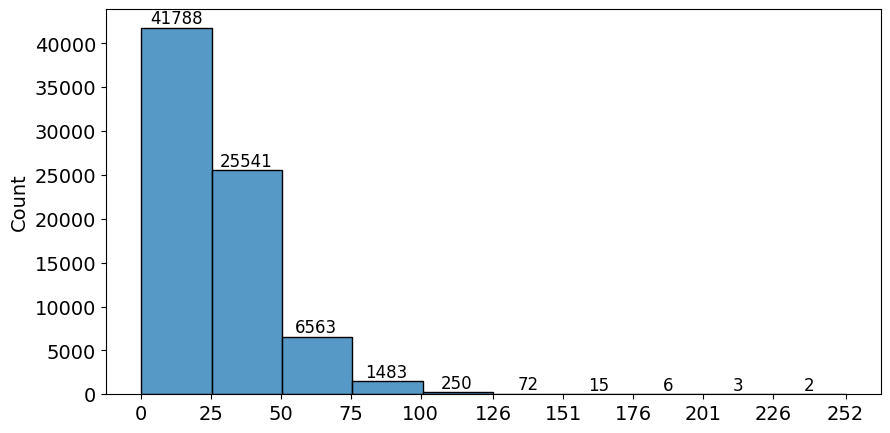

In [21]:
# 히스토그램의 범위 산정
hist_values, hist_bins = np.histogram(word_counts, range=(0, max_word_count), bins=10)
hist_bins = hist_bins.astype(np.int64)

plt.figure(figsize=(10, 5))
sb.histplot(word_counts, bins=10, binrange=(0, max_word_count))
plt.xticks(hist_bins, hist_bins)

for i, v in enumerate(hist_values):
    x = hist_bins[i] + ((hist_bins[i+1] - hist_bins[i]) / 2)
    plt.text(x=x, y=v, s=str(v), fontsize=12, verticalalignment='bottom', horizontalalignment='center')

plt.show()
plt.close()

## #06. 데이터 셋 분할하기

### 랜덤시드 고정

In [22]:
np.random.seed(777)

### 패딩처리

In [28]:
max_word_count = max(word_counts)
pad_token_set = pad_sequences(fill_token_set, maxlen=max_word_count)
pad_token_set

array([[   0,    0,    0, ..., 3059, 2770,    3],
       [   0,    0,    0, ...,    9,   28,    3],
       [   0,    0,    0, ..., 1867,    6,    3],
       ...,
       [   0,    0,    0, ...,    8,  490,  149],
       [   0,    0,    0, ...,    0,    0,  426],
       [   0,    0,    0, ...,    0,    0, 1641]])

### 훈련데이터와 검증데이터로 분할하기

In [29]:
x_train, x_test, y_train, y_test = train_test_split(pad_token_set, label_set, test_size=0.3, random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((53006, 252), (22717, 252), (53006,), (22717,))

### 종속변수(Label)에 대한 one-hot-encoding

In [30]:
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
print(y_test_one_hot)

[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


## #07. 모델 개발

### 모델 정의

In [31]:
#모델 개발
model = Sequential()

# input_dim의 크기는 토큰 생성시 지정한 최대 단어수(vocab_size)와 동일하게 설정
# output_dim의 크기는 input_dim보다 작은 값 중에서 설정
model.add(Embedding(input_dim = vocab_size, output_dim = 64))
model.add(GRU(256))
model.add(Dense(6, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          1222848   
                                                                 
 gru_1 (GRU)                 (None, 256)               247296    
                                                                 
 dense_1 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 1471686 (5.61 MB)
Trainable params: 1471686 (5.61 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


### 학습하기

In [32]:
# 파일이 저장될 경로(폴더) 지정 (한글,공백이 포함되어 있을 경우 에러 발생함)
if sys.platform == 'win32':
    checkpoint_path = "D:\\tensorflow_checkpoint\\cp-{epoch:04d}-ckpt"
else:
    checkpoint_path = "./model07-cp-{epoch:04d}-ckpt"

result = model.fit(x_train, y_train_one_hot, epochs=500, validation_data=(x_test, y_test_one_hot), callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1),
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True)
])

Epoch 1/500
  31/1657 [..............................] - ETA: 8:49 - loss: 1.7618 - acc: 0.2188

KeyboardInterrupt: 